In [1]:
# My imports
from pylab import *
import numpy as np
import pyfits,glob,time
from subprocess import call
topdir='/Users/cslage/Research/LSST/code/GUI/'
forwarddir ='/Users/cslage/Research/LSST/code/galsim-newgit/GalSim/devel/brighter-fatter/forward_model_varying_i'
%cd $forwarddir
import  forward
from scipy.optimize import fmin_powell
global spotlist

#Sergey's imports
import ngmix
from ngmix.fitting import LMSimple, MCMCSimple
import numpy as np
import posixpath, glob, datetime, os, sys
from astropy.io import fits as pyfits
from scipy.stats import binned_statistic_2d, binned_statistic
from tqdm import tqdm,tqdm_notebook

%matplotlib inline

/Users/cslage/Research/LSST/code/galsim-newgit/GalSim/devel/brighter-fatter/forward_model_varying_i


In [2]:
def run_sextractor(fitsfilename):
    configfile=topdir+'sextractor/30-micron-pinholes.sex'
    paramfile=topdir+'sextractor/default-array_dither.param'
    minadu=10
    outname=fitsfilename

    def make_reg_from_ldac(cat_ldac_file,text_tag):
        thecat=pyfits.getdata(cat_ldac_file,'LDAC_OBJECTS')
        f = open(cat_ldac_file+'.reg','w')
        for i in range(len(thecat)):
            xcoo,ycoo=thecat['XWIN_IMAGE'][i],thecat['YWIN_IMAGE'][i]
            r=thecat['A_IMAGE'][i]
            thetext=thecat[text_tag][i]
            f.write('circle '+str(xcoo)+' '+str(ycoo)+' '+str(r)+'#text="'+str(thetext)+'"\n')
        f.close()
 
    callstring=["sex",outname,"-c",configfile,"-CATALOG_NAME",outname+'.cat',"-CATALOG_TYPE","FITS_LDAC",
               "-CHECKIMAGE_NAME",outname[:-4]+"back.fits"+','+outname[:-4]+"rms.fits",
               "-CHECKIMAGE_TYPE","BACKGROUND,BACKGROUND_RMS",
               "-DETECT_THRESH","10","-DETECT_MINAREA","10","-THRESH_TYPE","RELATIVE","-DETECT_MAXAREA","400",
               "-ANALYSIS_THRESH","2"]

    test=call(callstring)
    make_reg_from_ldac(outname+'.cat','NUMBER')



First, we're going to compare the Lage forward modeling code with ngmix MCMC on fitting GalSim generated spots.  These spots have been generated using the code build_spots_9apr18.py.  There are 100 spots with a dithered location and a nominal sigma of 1.5 pixels.

In [3]:
thedir='/Users/cslage/Research/LSST/code/GUI/spot_sizes/'
filelist=sort(glob.glob(thedir+'bf_1.fits'))
print len(filelist)," files"


1  files


In [4]:
tstart=time.time()
for i in range(len(filelist)): run_sextractor(filelist[i])

print time.time()-tstart

0.235648870468


In [4]:
def Area(xl, xh, yl, yh, sigmax, sigmay, Imax):
    # Calculates how much of a 2D Gaussian falls within a rectangular box
    ssigx = sqrt(2) * sigmax
    ssigy = sqrt(2) * sigmay    
    I = (erf(xh/ssigx)-erf(xl/ssigx))*(erf(yh/ssigy)-erf(yl/ssigy))
    return Imax * I / 4.0

class Array2dSet:
    def __init__(self,xmin,xmax,nx,ymin,ymax,ny,nstamps):
        # This packages up a set of nstamps postage stamp images,
        # each image of which is nx * ny pixels
        self.nx=nx
        self.ny=ny
        self.nstamps=nstamps

        self.xmin=xmin
        self.ymin=ymin
        
        self.xmax=xmax
        self.ymax=ymax
        
        self.dx=(xmax-xmin)/nx
        self.dy=(ymax-ymin)/ny
        
        self.x=linspace(xmin+self.dx/2,xmax-self.dx/2,nx)
        self.y=linspace(ymin+self.dy/2,ymax-self.dy/2,ny)

        self.data=zeros([nx,ny,nstamps])
        self.xoffset=zeros([nstamps])
        self.yoffset=zeros([nstamps])
        self.x2=zeros([nstamps])
        self.y2=zeros([nstamps])
        self.xy=zeros([nstamps])
        self.imax=zeros([nstamps])

def BuildSpotList(fitsfilename, numspots, nx, ny, minsize, maxsize):
    global spotlist
    stampxmin = -(int(nx/2)+0.5)
    stampxmax = -stampxmin
    stampymin = -(int(ny/2)+0.5)
    stampymax = -stampymin
    xcoomin = 0
    xcoomax = 200
    ycoomin = 0
    ycoomax = 200
    spotlist = Array2dSet(stampxmin,stampxmax,nx,stampymin,stampymax,ny,numspots)
    hdr=pyfits.getheader(fitsfilename)
    img=pyfits.getdata(fitsfilename) 
    catname=fitsfilename[:-5]+'.fits.cat.reg' 
    catfile = open(catname,'r')
    catlines = catfile.readlines()
    catfile.close()
    n=0
    for line in catlines:
        try:
            size = float(line.split()[3].split('#')[0])
            if size < minsize or size > maxsize:
                continue
            xcoord = float(line.split()[1])
            ycoord = float(line.split()[2])
            if xcoord < xcoomin or xcoord > xcoomax or ycoord < ycoomin or ycoord > ycoomax:
                continue
            xint = int(xcoord-0.5)
            yint = int(ycoord-0.5)
            xmin = xint - int(nx/2)
            xmax = xint + int(nx/2) + 1
            ymin = yint - int(ny/2)
            ymax = yint + int(ny/2) + 1
            stamp = img[ymin:ymax, xmin:xmax]
           
            xsum = 0.0
            ysum = 0.0
            datasum = 0.0
             
            for i in range(nx):
                for j in range(ny):
                    spotlist.data[i,j,n] = float(stamp[j,i])                    
                    ysum += spotlist.y[j] * spotlist.data[i,j,n]
                    xsum += spotlist.x[i] * spotlist.data[i,j,n]
                    datasum += spotlist.data[i,j,n]
            xoff = xsum / datasum
            yoff = ysum / datasum
            spotlist.xoffset[n] = xoff
            spotlist.yoffset[n] = yoff

            x2sum = 0.0
            y2sum = 0.0
            xysum = 0.0
            datasum = 0.0
             
            for i in range(nx):
                for j in range(ny):
                    spotlist.data[i,j,n] = float(stamp[j,i])                    
                    x2sum += (spotlist.x[i] - spotlist.xoffset[n]) * (spotlist.x[i] - spotlist.xoffset[n]) * spotlist.data[i,j,n]
                    y2sum += (spotlist.y[j] - spotlist.yoffset[n]) * (spotlist.y[j] - spotlist.yoffset[n]) * spotlist.data[i,j,n]
                    xysum += (spotlist.x[i] - spotlist.xoffset[n]) * (spotlist.y[j] - spotlist.yoffset[n]) * spotlist.data[i,j,n]
                    datasum += spotlist.data[i,j,n]
            xoff = xsum / datasum
            yoff = ysum / datasum
            spotlist.x2[n] = x2sum / datasum
            spotlist.y2[n] = y2sum / datasum
            spotlist.xy[n] = xysum / datasum
                    
            n += 1
            if n == numspots:
                return spotlist
        except:
            continue
    # Reaching this point means we found less spots than requested.
    newspotlist = Array2dSet(stampxmin,stampxmax,nx,stampymin,stampymax,ny,n)
    newspotlist.xoffset = spotlist.xoffset[0:n]
    newspotlist.yoffset = spotlist.yoffset[0:n]
    newspotlist.x2 = spotlist.x2[0:n]
    newspotlist.y2 = spotlist.y2[0:n]
    newspotlist.xy = spotlist.xy[0:n]
    newspotlist.data = spotlist.data[:,:,0:n]
    del spotlist
    return newspotlist

def FOM(params):
    global spotlist
    [sigmax, sigmay] = params
    result = forward.forward(spotlist,sigmax,sigmay)
    return result

def SingleSpotList(inputspotlist, n):
    global spotlist
    stampxmin = inputspotlist.xmin
    stampxmax = inputspotlist.xmax
    nx = inputspotlist.nx
    stampymin = inputspotlist.ymin
    stampymax = inputspotlist.ymax
    ny = inputspotlist.ny
    spotlist = Array2dSet(stampxmin,stampxmax,nx,stampymin,stampymax,ny,1)
    spotlist.xoffset = inputspotlist.xoffset[n:n+1]
    spotlist.yoffset = inputspotlist.yoffset[n:n+1]
    spotlist.x2 = inputspotlist.x2[n:n+1]
    spotlist.y2 = inputspotlist.y2[n:n+1]
    spotlist.xy = inputspotlist.xy[n:n+1]
    spotlist.data = inputspotlist.data[:,:,n:n+1]
    return spotlist

def ReadCCFile(filename, Nx, Ny):
    file = open(filename,'r')
    lines=file.readlines()
    file.close()
    lines.remove(lines[0]) # Strip the title line
    elec = zeros([Nx,Ny])
    count = 0
    for line in lines:
        items = line.split()
        i = int(items[0]) - 1
        j = int(items[1]) - 1        
        elec[i,j] = int(items[2])

    return elec


In [5]:
# We build the list of spots with 9x9 postage stamps
spotlist = BuildSpotList(filelist[0], 100, 9, 9, 1.3, 1.7)
param0 = [1.0, 1.0]
args = ()#(spotlist)
Result = fmin_powell(FOM, param0, args)
print spotlist.nstamps
print Result


Optimization terminated successfully.
         Current function value: 4387482.510491
         Iterations: 3
         Function evaluations: 73
100
[1.50001095 1.5000127 ]


100


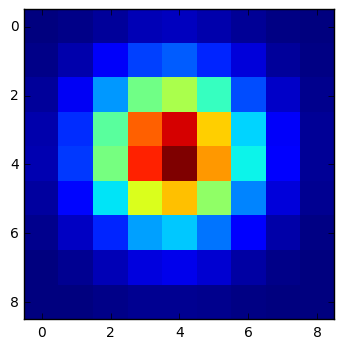

In [6]:
# Let's look at a random spot
print spotlist.nstamps
imshow(spotlist.data[:,:,33],interpolation='Nearest')

As expected, the forward modeling code returns exactly 1.5 pixels for the best fit sigma of all 100 spots
Now let's try using NGMIX on the same spots.  I don't see how to use NGMIX to fit a whole set of spots, so we'll compare the results on one spot at a time. Note that I had to increase the guess for 2*sigma^2 in get_sigma to get it to return reasonable values.

In [8]:
# Imported from Sergey's NGMIX notebook
# Added a sigma_guess to speed convergence
def srandu(num=None):
#  Generate random numbers in the symmetric distribution [-1,1]
    return 2*(np.random.random(num)-0.5)

def get_sigma(img, weight_map=None, xc=4.0, yc=4.0, sigma_guess=0.4, nwalkers=80, burnin=400, nstep=400):
    guess=np.zeros((nwalkers, 6))

    if weight_map is None:
        weight_map = 1./np.sqrt(np.fabs(img))
        
    obs = ngmix.observation.Observation(img, weight=weight_map)
    mc = MCMCSimple(obs, 'gauss', nwalkers=nwalkers, nsub=4)
    guess[:,0] = xc + 0.1*srandu(nwalkers)
    guess[:,1] = yc + 0.1*srandu(nwalkers)
    guess[:,2] = 0. + 0.1*srandu(nwalkers)
    guess[:,3] = 0. + 0.1*srandu(nwalkers)
    guess[:,4] = 2.0 * sigma_guess * sigma_guess * (1.0 + 0.1*srandu(nwalkers))
    guess[:,5] = np.sum(img) * (1.0 + 0.1*srandu(nwalkers))

    pos = mc.run_mcmc(guess, burnin)
    pos = mc.run_mcmc(pos,   nstep)

    mc.calc_result()

    result = mc.get_result()

    if result['flags'] == 0:
        #print result['pars']
        return result['pars'][0], result['pars'][1], np.sqrt(result['pars'][4]/2.0)
    else:
        return 0.0, 0.0, 0.0


In [68]:
# NGMIX is very slow, so we'll just do 25 spots
fullspotlist = BuildSpotList(filelist[0], 100, 9, 9, 1.3, 1.7)

ngmix_sigma = []
forward_sigma = []
nspot = 20
numspots = 0
while numspots < 25:
    spotlist = SingleSpotList(fullspotlist, nspot)
    img = spotlist.data[:,:,0]
    # First, run the forward modeling
    param0 = [1.0, 1.0]
    args = ()#(spotlist)
    Result = fmin_powell(FOM, param0, args)

    # Next run NGMIX with MCMC
    xc,yc = 4.5, 4.5
    yc,xc,ng_sigma = get_sigma(img, xc=yc, yc=xc, sigma_guess = 1.5, nstep=400)
    if (not isnan(ng_sigma)) and ng_sigma > 1.2 and ng_sigma < 1.8:
        ngmix_sigma.append(ng_sigma)
        for_sigma = (Result[0] + Result[1])/2.0
        forward_sigma.append(for_sigma)
        print for_sigma, ng_sigma
        numspots += 1
        nspot += 1




Optimization terminated successfully.
         Current function value: 33595.984899
         Iterations: 3
         Function evaluations: 73
1.5000098527226544 1.5017450564539685
Optimization terminated successfully.
         Current function value: 71859.771710
         Iterations: 3
         Function evaluations: 73
1.5000187244662273 1.501731034694413
Optimization terminated successfully.
         Current function value: 56735.517701
         Iterations: 3
         Function evaluations: 76
1.5000158555680914 1.5017436161008781
Optimization terminated successfully.
         Current function value: 83574.396786
         Iterations: 3
         Function evaluations: 73
1.5000221272040628 1.5017587310206755
Optimization terminated successfully.
         Current function value: 48605.861572
         Iterations: 3
         Function evaluations: 73
1.500012855761179 1.5017136539322724
Optimization terminated successfully.
         Current function value: 16224.694553
         Iterations: 3


In [69]:
print array(ngmix_sigma).mean(), array(ngmix_sigma).std(), array(forward_sigma).mean(), array(forward_sigma).std(), 

1.5017364865552443 1.3914395923641634e-05 1.500011149129599 7.6167348907006136e-06


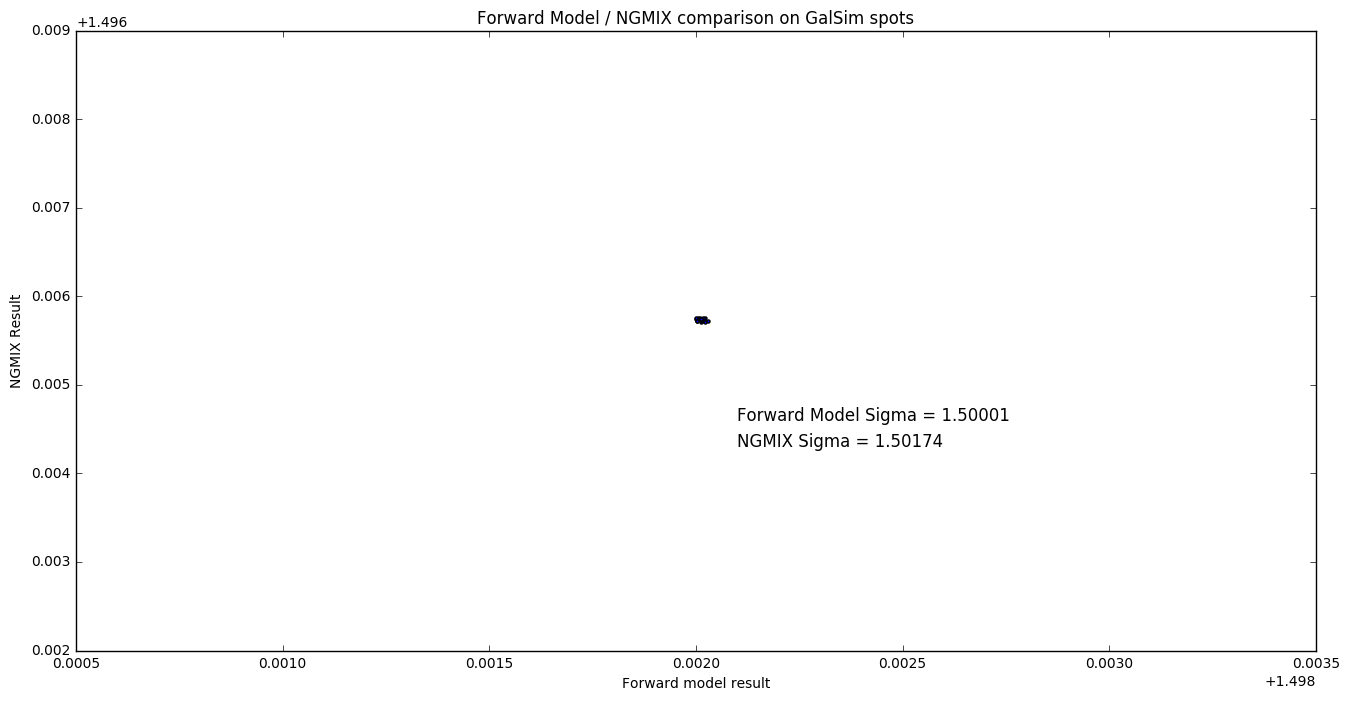

In [70]:
# Now let's plot the results
figure(figsize = (16,8))
title("Forward Model / NGMIX comparison on GalSim spots")
scatter(forward_sigma, ngmix_sigma, s=5.0)
xlabel("Forward model result")
ylabel("NGMIX Result")
#xlim(1.4995,1.5005)
#ylim(1.4995,1.5005)
text(1.5001,1.5006,"Forward Model Sigma = %.5f"%array(forward_sigma).mean(),fontsize = 12)
text(1.5001,1.5003,"NGMIX Sigma = %.5f"%array(ngmix_sigma).mean(),fontsize = 12)
savefig(thedir+"Forward_NGMIX_Comparison_10APR18.png")



NGMIX is much slower and has more scatter, but basically the two codes agree that the spot sizes are 1.5 microns.
So where is the discrepancy? Next I'll try to understand how Sergey converted the *Pts.dat files into images.  I have been using the *CC.dat files, which only have the number of electrons in each pixel.

[[   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.  124. 1278.    0.    0.]
 [   0.    0.   28.  190.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]]
[[   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.  124. 1278.    0.    0.    0.]
 [   0.   28.  190.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]]
0.23069819861335783



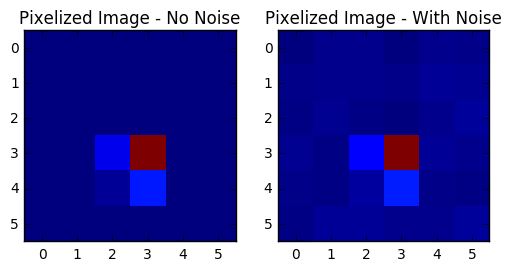

In [9]:
base = '/Users/cslage/Research/LSST/code/poisson/Poisson_CCD_Hole20_Fe55/data/skrun1/Pixel'

x0s,y0s,x1s,y1s = [],[],[],[]
sigmas = []

noise = 10.0

for iter in tqdm_notebook(xrange(1)): # Process first 100 spots from given directory
    filename = '%s_%d_Pts.dat' % (base, iter)
    if posixpath.exists(filename):

        id,step,ph,x,y,z = np.loadtxt(filename, skiprows=1, unpack=True)
        
        id0 = id[ph==0]
        x0,x1 = x[ph==0], x[ph!=0] # Initial coordinates of electron
        y0,y1 = y[ph==0], y[ph!=0] # Final coordinates of electron

        gmag0, xe, ye, binnumbers = binned_statistic_2d(x0, y0, x1-x0, bins=[6,6], statistic='count', range=[[0,60],[0,60]])
        gmag1, xe, ye, binnumbers = binned_statistic_2d(x1, y1, x1-x0, bins=[6,6], statistic='count', range=[[0,60],[0,60]])
        img0 = gmag0.T # Pixelization of initial locations
        img1 = gmag1.T # Pixelization of final locations
        # Compare Sergey's pixelization to my CC file
        print img1
        ccfilename = filename = '%s_%d_CC.dat' % (base, iter)
        ccfile = ReadCCFile(filename, 9, 9)
        print ccfile[0:6,0:6].T
        figure()
        subplot(1,2,1)
        title("Pixelized Image - No Noise")
        imshow(img1, interpolation='Nearest')

        # Rough centroid estimation for Gaussian fitting
        xx,yy = np.meshgrid(np.arange(6), np.arange(6))
        xc,yc = np.sum(xx*img1)/np.sum(img1), np.sum(yy*img1)/np.sum(img1)
        
        # Add artificial read-out noise
        img = img1 + np.random.normal(scale=noise, size=img1.shape)
        subplot(1,2,2)
        title("Pixelized Image - With Noise")
        imshow(img, interpolation='Nearest')

        weight_map = np.ones_like(img)*1./noise**2

        # Get peak position using MCMC
        yc,xc,sigma = get_sigma(img, weight_map=weight_map, sigma_guess = 0.24, xc=yc, yc=xc, nstep=400)
        
        # If the fit properly converged, store this spot parameters
        if xc > 0 and xc < 6 and yc > 0 and yc < 6 and sigma > 0 and sigma < 10:
            sigmas.append(sigma)
            x0s.append(np.mean(x0))
            y0s.append(np.mean(y0))
            x1s.append(xc)
            y1s.append(yc)
            print sigma



Sergey's pixelization agrees exactly with my CC file, with an offset that won't matter.  So the problem lies elsewhere.  Notice that the sigma extracted for this one spot is much smaller than the sigma extracted from a group of spots.  What if I run my forward modeling on one of these spots?  It will probably come out much smaller.

In [10]:
spotlist = BuildSpotList(filelist[0], 1, 5, 5, 1.3, 1.7)
spotlist.data[:,:,0] = img1[1:6,1:6]

param0 = [1.0, 1.0]
args = ()#(spotlist)
Result = fmin_powell(FOM, param0, args)
print Result, (Result[0] + Result[1]) / 2.0


Optimization terminated successfully.
         Current function value: 37214.476549
         Iterations: 2
         Function evaluations: 60
[0.04699313 0.27557754] 0.1612853330933656


Now let's try it on an actual run.

0.2759747423297073
0.28629060098944203
0.2708315005131567
0.2421787105849473
0.22733900334043664
0.28658963338801874
0.23770352799079764
0.22462746150795737
0.22870505602826433
0.2091704156496447
0.2865989569127287
0.20351736250000757
0.23950399253775306
0.20752246232993937
0.21541069219490508
0.2392547104411367
0.2632237026616246
0.19661164063671377
0.23520678246383966
0.30036841591409785
0.1753664402506771
0.21389393023496237
0.2886577653351991
0.254560691239935
0.2847041281118101
0.20863851416025253
0.24420930235545293
0.16520834282677818
0.29033943454145533
0.277429529683092
0.16674944718606893
0.22505378560238873
0.24133397036240556
0.26071521906243417
0.29536777092232597
0.24195527267952285
0.28573221257245873
0.2316822541498877
0.2521376627986918
0.24893956168472584
0.20284717282820092
0.20525997707235943
0.22658505643831214
0.18531331034181664
0.14896214478308847
0.1732904906073773
0.16276734112260494
0.17489921772503156
0.17287169333132107
0.2119183276293085
0.2603580453220188

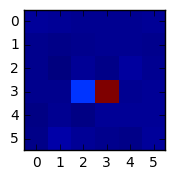

In [26]:
base = '/Users/cslage/Research/LSST/code/poisson/Poisson_CCD_Hole20_Fe55/data/llnl_fe55_16/cc_files/'

x0s,y0s,x1s,y1s = [],[],[],[]
sigmas = []

noise = 10.0

stacked_image = zeros([6,6])

for iter in range(128): # Process first 64 spots from given directory
    filename = base+'run_%d/Pixel_0_Pts.dat' % iter
    if posixpath.exists(filename):
        try:
            id,step,ph,x,y,z = np.loadtxt(filename, skiprows=1, unpack=True)
        
            id0 = id[ph==0]
            x0,x1 = x[ph==0], x[ph!=0] # Initial coordinates of electron
            y0,y1 = y[ph==0], y[ph!=0] # Final coordinates of electron

            gmag0, xe, ye, binnumbers = binned_statistic_2d(x0, y0, x1-x0, bins=[6,6], statistic='count', range=[[0,60],[0,60]])
            gmag1, xe, ye, binnumbers = binned_statistic_2d(x1, y1, x1-x0, bins=[6,6], statistic='count', range=[[0,60],[0,60]])
            img0 = gmag0.T # Pixelization of initial locations
            img1 = gmag1.T # Pixelization of final locations
            stacked_image = stacked_image + img1
            # Rough centroid estimation for Gaussian fitting
            xx,yy = np.meshgrid(np.arange(6), np.arange(6))
            xc,yc = np.sum(xx*img1)/np.sum(img1), np.sum(yy*img1)/np.sum(img1)
        
        # Add artificial read-out noise
            img = img1 + np.random.normal(scale=noise, size=img1.shape)
            subplot(2,2,3)
            imshow(img, interpolation='Nearest')

            weight_map = np.ones_like(img)*1./noise**2

            # Get peak position using MCMC
            yc,xc,sigma = get_sigma(img, weight_map=weight_map, sigma_guess = 0.24, xc=yc, yc=xc, nstep=400)
        
            # If the fit properly converged, store this spot parameters
            if xc > 0 and xc < 6 and yc > 0 and yc < 6 and sigma > 0 and sigma < 10:
                sigmas.append(sigma)
                x0s.append(np.mean(x0))
                y0s.append(np.mean(y0))
                x1s.append(xc)
                y1s.append(yc)
                print sigma
        except:
            continue


        
sigmas,x0s,y0s,x1s,y1s = [np.array(_) for _ in sigmas,x0s,y0s,x1s,y1s]

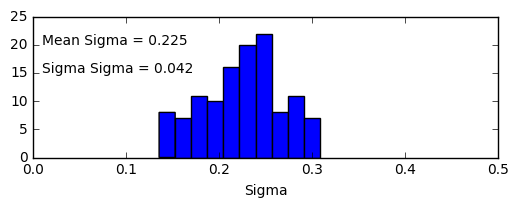

In [27]:
subplot(211)
hist(sigmas, bins=10);
xlabel('Sigma')
xlim(0.0,0.5)
text(0.01,20.0,"Mean Sigma = %.3f"%sigmas.mean())
text(0.01,15.0,"Sigma Sigma = %.3f"%sigmas.std())
savefig(thedir+"Spot_by_Spot_Sigmas_Run16_10Apr18.png")

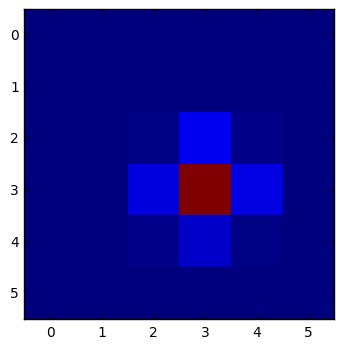

In [28]:
imshow(stacked_image, interpolation='Nearest')
savefig(thedir+"Stacked_Map_Run16_10Apr18.png")

In [29]:
stacked_image = stacked_image + np.random.normal(scale=noise, size=stacked_image.shape)
weight_map = np.ones_like(stacked_image)*1./noise**2

yc,xc,sigma = get_sigma(stacked_image, weight_map=weight_map, xc=3.0, yc=3.0, nstep=40)

In [20]:
print "Run 14, Electrons and Holes Mutual Interactions", xc, yc, sigma

Run 14, Electrons and Holes Mutual Interactions 3.0474652927987758 3.0105318270228043 0.3900681832359996


In [25]:
print "Run 15, Only Electron Mutual interactions", xc, yc, sigma

Run 15, Only Electron Mutual interactions 3.0076399955306106 2.9969195335468894 0.3841123709649985


In [30]:
print "Run 16, No Mutual Interactions", xc, yc, sigma

Run 16, No Mutual Interactions 3.0074719528773017 2.9605132308759243 0.34843538799170065
